<h1> Barcelona case study </h1>
<h2> Local coffee shop vs gourmet restaurant </h2>

<h3> Introduction </h3>

<p>In this case study, I want to research different characteristics that would make it feasible to open either a local coffee shop, compared to opening a gourmet restaurant, in the city of Barcelon </p>
<p>Barcelona is chosen in this example since it is the city I am currently residing in and the one I am more familiar with in the present. Therefore, I already have some idea on what is the solution of the problem and I am just trying to back it up with some data analysis. </p>

<h4> Context </h4>

<p>For this case study, we are interested in some particular data of the city. Obviously, the more characteristics you take into account the deeper the analysis, but I will just focus on what I consider essential. Feel free to point out more data that could be used to solve the problem!. </p>
<p>To determine where to open a food local, the easiest thing one can do is to look where most of these locals are situated in the present. To do that, we will download the data of every district in Barcelona, looking for top 100 venues of each area. Analyzing where most of the food-related locals are would help us get an idea on where to open our local. At least where to open a coffee shop</p>
<p>In the case of a gourmet restaurant, it might be a bit more complicated. For that, we will analyze the rent per capita of each of the neighbourhoods. The more rent, the more probabilities they will go to an expensive restaurant! </p>
<p> Finally we should take into consideration Barcelona is a rather touristic city. Will our gourmet restaurant cater to locals or it will be more international? Those two options will be determined by the number of hotels in the area! </p>

<h4> Data sources </h4>

<p>Different data sources will be used in this study. These include:</p><br>
<li><a href "https://www.bcn.cat/estadistica/catala/dades/barris/economia/renda/rdfamiliar/a2017.htm"> Barcelona city hall data: </a> It is the base of the study, includes a list of districts, neighborhoods and rent per capita.</li>
<li><a href "https://ca.wikipedia.org/wiki/Districtes_i_barris_de_Barcelona"> Wikipedia page for Barcelona districts: </a> Used to get the names of the districts. </li>
<li>Foursquare API: Used to get the data on the venues of each neighborhood.</li>

<h3> Coding </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as pltcolors
import seaborn as sns
from bs4 import BeautifulSoup
import requests
!pip install folium
import folium
!pip install geopy
import geopy
from geopy.geocoders import Nominatim
import branca
import branca.colormap as brcm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
print("Libraries imported!")

     |████████████████████████████████| 93 kB 3.7 MB/s  eta 0:00:01
Libraries imported!


<h6>Obtaining the base data </h6>

<p>First, we will extract the data of the rent per capita from the city of Barcelona website (barcelona.cat). They use what they call the "RFD" index, that is an index chosen to be equal to 100 for the average of the city. The higher you are from this value, the higher the rent, and viceversa. The last data they have is from 2017, which is the one we will use in this case </p>

In [2]:
#First lets download the page
page = requests.get("https://www.bcn.cat/estadistica/catala/dades/barris/economia/renda/rdfamiliar/a2017.htm")
#Lets acces the webpage and create the dataframe
soup = BeautifulSoup(page.content, 'html.parser');

In [3]:
#Checking the code of the webpage, we can see the table is not very scraple friendly, we must access all the rows "tr" directly
tdata = soup.find_all('tr');
#We create an initial dataframe with these columns.
df = pd.DataFrame();
df['names_raw'] = np.nan; df['Population'] = np.nan; df['RFD'] = np.nan;

In [4]:
#From there, we can see that our data starts in row number 9 and it must contain the 73 neighborhoods so we loop until 9+73 rows
for row in range(9, 9+73):
    df.loc[row-9,'names_raw'] = tdata[row].find_all('td')[0].text;
    df.loc[row-9,'Population'] = tdata[row].find_all('td')[1].text;
    df.loc[row-9,'RFD'] = tdata[row].find_all('td')[2].text;

In [5]:
#There's some work that needs to be done with the neighborhood column. First, we'll split the first number (representing the district)
df[['District','Neighborhood']]  = df['names_raw'].str.split('\xa0\xa0\xa0\xa0\xa0',expand=True);

#Then we'll split the name from the neighborhood number
df[['Neigh_id','Neigh_name']]  = df['Neighborhood'].str.split('\. ',expand=True);

#We need to take care of the whitespaces after our cells
df['Neigh_name'] = df['Neigh_name'].str.replace('\xa0\xa0','');
df['Population'] = df['Population'].str.replace('\xa0\xa0',''); df['Population'] = df['Population'].str.replace('.','');
df['RFD'] = df['RFD'].str.replace('\xa0\xa0',''); df['RFD'] = df['RFD'].str.replace(',','.');

#Finally, we'll convert the population column to integer and the RFD to float, as well as neighborhood and district numbers
df.Neigh_id = df.Neigh_id.astype(int);
df.District = df.District.astype(int);
df.Population = df.Population.astype(int);
df.RFD = df.RFD.astype(float);

#Now let's get rid of unwanted columns
df.drop(['names_raw', 'Neighborhood'], axis=1, inplace=True);


In [6]:
#I forgot to include the names of the districts (not present in every table of the city hall, but they can easily be obtained from wikipedia)
page = requests.get("https://ca.wikipedia.org/wiki/Districtes_i_barris_de_Barcelona")
#Lets acces the webpage and create the dataframe
soup = BeautifulSoup(page.content, 'html.parser');
tdata = soup.find('table');
df_district = pd.read_html(str(tdata))[0];
df_district.drop(df_district.tail(1).index,inplace=True) 
df_district = df_district[['Núm.','Districte']];
df_district.rename(columns={'Núm.': 'District', 'Districte': 'District_name'}, inplace=True);
df_district.District = df_district.District.astype(int);
df = df.merge(df_district, on="District", how="left");

#Finally, our base data is processed!
df = df[['District', 'District_name','Neigh_id', 'Neigh_name', 'Population', 'RFD']];

<p> The processed data can be seen below. This process might be a bit tedious, but once the code is figure out, it is a much powerful method. For example, in this case we chose to only work with the data from 2017, but with this code, we could easily analyse the other years uploaded in the website, and maybe build a regression model to obtain what would be the data of 2020. In this case, this has been considered to be out of scope, but something that can be easily built upon. </p>

In [7]:
df.head()

,District,District_name,Neigh_id,Neigh_name,Population,RFD
0,1,Ciutat Vella,1,el Raval,47986,71.2
1,1,Ciutat Vella,2,el Barri Gòtic,16240,106.1
2,1,Ciutat Vella,3,la Barceloneta,15101,79.6
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22923,99.4
4,2,Eixample,5,el Fort Pienc,32048,106.5


<h6> Obtaining the locations of each neighborhood </h6>

<p>The next step is to get the coordinates of each neighborhood. To do that we use the geopy library, introduce the name of each neighborhood (with "Barcelona" attached in the address) to obtain the latitude and longitude of each area. </p>

In [8]:
geolocator = Nominatim(user_agent='bcn_explorer');
#After running this code, I found out there are two locations that could not be found, therefore I rewrite the neighborhood name here:
#Rewrite these two particular locations
df.loc[10,'Neigh_name'] = 'el Poble Sec';
df.loc[11,'Neigh_name'] = 'la Marina del Prat Vermell';

df['Address'] = df['Neigh_name'] + ', Barcelona';
df['Latitude'] = np.nan; df['Longitude'] = np.nan;

#Applying the method to pandas DataFrame
df['location'] = df['Address'].apply(geolocator.geocode)
df['Latitude'] = df['location'].apply(lambda x: x.latitude if x else None)
df['Longitude'] = df['location'].apply(lambda x: x.longitude if x else None)

<p>Before proceeding, we should chech if all the neighborhoods have been located by our geolocator: </p>

In [9]:
#Let's check if there are any rows the geolocator could not find
df[df['Longitude'].isna()]

,District,District_name,Neigh_id,Neigh_name,Population,RFD,Address,Latitude,Longitude,location


<p>Everything seems to be correct! We can take a look into our dataframe:</p>

In [10]:
#Let's just drop the location column, we'll keep the address one to find the nearest venues!
df.drop('location', axis=1, inplace=True);

In [11]:
df.head()

,District,District_name,Neigh_id,Neigh_name,Population,RFD,Address,Latitude,Longitude
0,1,Ciutat Vella,1,el Raval,47986,71.2,"el Raval, Barcelona",41.379518,2.168368
1,1,Ciutat Vella,2,el Barri Gòtic,16240,106.1,"el Barri Gòtic, Barcelona",41.383395,2.176912
2,1,Ciutat Vella,3,la Barceloneta,15101,79.6,"la Barceloneta, Barcelona",41.380653,2.189927
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22923,99.4,"Sant Pere, Santa Caterina i la Ribera, Barcelona",41.388322,2.177411
4,2,Eixample,5,el Fort Pienc,32048,106.5,"el Fort Pienc, Barcelona",41.395925,2.182325


<h6> Obtaining the venue data for each location </h6>

In [12]:
#Define Foursquare credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500;

# Credentials deleted before uploading

<p>We are interested in two particular types of venues: Food and hotels. Therefore, we will restrict our search into these two categories, finding out which areas have more restaurants and hotels, in absolute value. I am taking this approach since Foursquare categories are extremely precise and at this point of the study it does not matter wheter a restaurant is "Spanish restaurant" or "Spanish tapas" or anything in between.</p>

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius, categoryId):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<p>First let's obtain all the data from the restaurants in Barcelona: </p>

In [14]:
categoryId = '4d4b7105d754a06374d81259';
bcn_food = getNearbyVenues(names=df['Neigh_name'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius, categoryId=categoryId);

In [15]:
print('The code returned', bcn_food.shape[0],' restaurants!');
print('There are {} uniques categories!'.format(len(bcn_food['Venue Category'].unique())))
bcn_food_grp = bcn_food[['Neighborhood', 'Venue']].groupby('Neighborhood').count()
bcn_food_grp.reset_index(inplace=True);
bcn_food_grp.rename(columns={'Neighborhood': 'Neigh_name', 'Venue': 'Restaurants'}, inplace=True);
bcn_food_grp

The code returned 3234  restaurants!
There are 122 uniques categories!


,Neigh_name,Restaurants
0,Baró de Viver,32
1,Can Baró,50
2,Can Peguera,47
3,Canyelles,15
4,Ciutat Meridiana,12
...,...,...
66,la Vila Olímpica del Poblenou,49
67,la Vila de Gràcia,50
68,les Corts,50
69,les Roquetes,45


<p> Now let's obtain the data in hotels from Barcelona </p>

In [16]:
categoryId = '4bf58dd8d48988d1fa931735';
bcn_hotel = getNearbyVenues(names=df['Neigh_name'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius, categoryId=categoryId);

In [17]:
print('The code returned', bcn_hotel.shape[0],' hotels!');
print('There are {} uniques categories!'.format(len(bcn_hotel['Venue Category'].unique())))
bcn_hotel_grp = bcn_hotel[['Neighborhood', 'Venue']].groupby('Neighborhood').count();
bcn_hotel_grp.reset_index(inplace=True);
bcn_hotel_grp.rename(columns={'Neighborhood': 'Neigh_name', 'Venue': 'Hotels'}, inplace=True);
bcn_hotel_grp

The code returned 1176  hotels!
There are 17 uniques categories!


,Neigh_name,Hotels
0,Can Baró,5
1,Can Peguera,2
2,Diagonal Mar i el Front Marítim del Poblenou,18
3,Horta,3
4,Hostafrancs,49
...,...,...
59,la Vila Olímpica del Poblenou,26
60,la Vila de Gràcia,43
61,les Corts,23
62,les Roquetes,2


<p> Like previously discussed, at this point of the project we are not going to dive into every different type of hotel and restaurant, so we will join to our main dataframe the number of restaurants and hotels in absolute numbers </p>

In [18]:
df = df.merge(bcn_food_grp, on="Neigh_name", how="left");
df = df.merge(bcn_hotel_grp, on="Neigh_name", how="left");

In [19]:
#Let's proceed to do some last data cleaning
#First let's get read of whatever NaN in Hotels and Restaurants columns
df.Hotels = df.Hotels.replace(np.nan, 0);
df.Restaurants = df.Restaurants.replace(np.nan, 0);
#Now let's change the type to int
df.Restaurants = df.Restaurants.astype(int);
df.Hotels = df.Hotels.astype(int);

<p> Finally, we obtained the dataframe we will base our clustering on! </p>

In [20]:
df.head()

,District,District_name,Neigh_id,Neigh_name,Population,RFD,Address,Latitude,Longitude,Restaurants,Hotels
0,1,Ciutat Vella,1,el Raval,47986,71.2,"el Raval, Barcelona",41.379518,2.168368,50,48
1,1,Ciutat Vella,2,el Barri Gòtic,16240,106.1,"el Barri Gòtic, Barcelona",41.383395,2.176912,50,48
2,1,Ciutat Vella,3,la Barceloneta,15101,79.6,"la Barceloneta, Barcelona",41.380653,2.189927,50,48
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22923,99.4,"Sant Pere, Santa Caterina i la Ribera, Barcelona",41.388322,2.177411,50,49
4,2,Eixample,5,el Fort Pienc,32048,106.5,"el Fort Pienc, Barcelona",41.395925,2.182325,50,46


<h3> Data exploration </h3>

<p> Before doing any clustering, let's plot some data and try to understand what we have in hands. Since there 73 neighborhoods, it is diffcult to plot the data one by one, thus we will first group de thata by district for a first glance. </p>

In [21]:
#Differnt columns require different aggregations:
def df_grouping(x):
    d = {}
    d['Population'] = x['Population'].sum() #Population will be aggregated
    d['RFD'] = (x['RFD']*x['Population']).sum()/x['Population'].sum() #The RFD must be calculated as average but weighted by population
    d['Restaurants'] = x['Restaurants'].sum() # Restaurants will be aggregated
    d['Hotels'] = x['Hotels'].sum() #Hotels will be aggregated
    return pd.Series(d, index=['Population', 'RFD', 'Restaurants', 'Hotels'])

In [25]:
df_grouped = df[['District','District_name','Population','RFD','Restaurants','Hotels']].groupby(['District', 'District_name']).apply(df_grouping)
df_grouped.Restaurants = df_grouped.Restaurants.astype(int);
df_grouped.Hotels = df_grouped.Hotels.astype(int);
df_grouped.Population = df_grouped.Population / 1000; #We express the population in thousands
df_grouped.reset_index(inplace=True);
#df_grouped.rename(columns={'Population': 'Population (K)'}, inplace=True);
df_grouped

,District,District_name,Population,RFD,Restaurants,Hotels
0,1,Ciutat Vella,102.250,84.305653,200,193
1,2,Eixample,267.184,122.445749,300,280
2,3,Sants-Montjuïc,182.354,84.592545,392,179
3,4,Les Corts,82.201,137.294018,146,41
4,5,Sarrià - Sant Gervasi,149.734,182.792187,252,100
5,6,Gràcia,121.566,105.342970,198,104
6,7,Horta-Guinardó,169.187,77.972005,515,69
7,8,Nou Barris,166.805,55.011607,469,24
8,9,Sant Andreu,147.693,74.620786,266,19
9,10,Sant Martí,236.163,88.139150,496,167


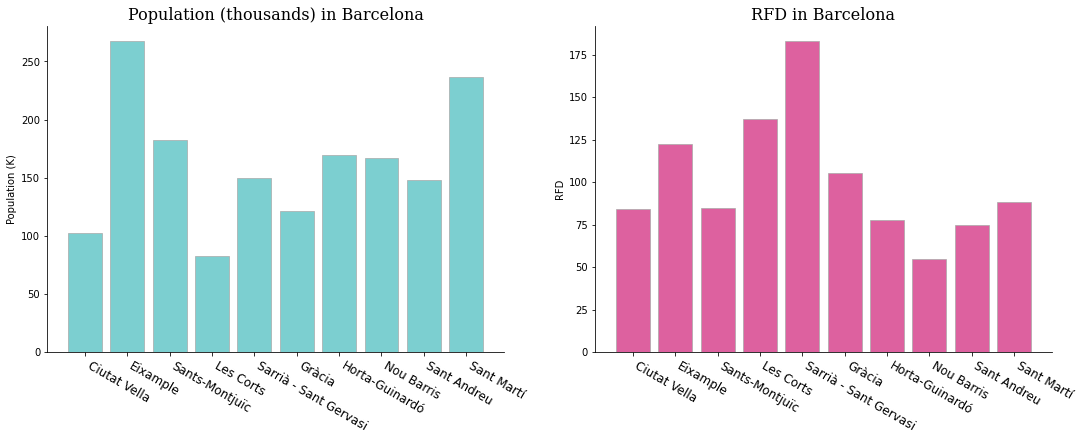

In [31]:
colors = ['#7CCFD0']*len(df_grouped.District_name);
colors[1] = ['#DD619F']*len(df_grouped.District_name);

fig, axs = plt.subplots(1,2, figsize=(18, 6))

axs[0].bar(df_grouped.District_name, df_grouped.Population, width=0.8,
         edgecolor='darkgray',  color=colors[0],
         linewidth=0.7)

axs[1].bar(df_grouped.District_name, df_grouped.RFD, width=0.8,
         edgecolor='darkgray',  color=colors[1],
         linewidth=0.7)

for ax in axs.flat:
    ax.spines['right'].set_visible(False); 
    ax.spines['top'].set_visible(False);
    ax.set_xticklabels(df_grouped.District_name,  fontsize=12, rotation=-30, ha="left")

axs[0].set(ylabel='Population (K)')
axs[0].set_title('Population (thousands) in Barcelona', fontsize=16, fontfamily='serif') # add title to the plot

axs[1].set(ylabel='RFD')
axs[1].set_title('RFD in Barcelona', fontsize=16, fontfamily='serif') # add title to the plot
    
plt.show()

<p> From these two barplots, we can see that the most populated district is Eixample, followed by Sant Martí, whereas the least populated district is Les Corts. On the other hand, the RFD in Barcelona is highest in Sarrià, followed by Les Corts, with the lowest being in Nou Barris. <i> As explained before, the RFD index measures the rent per capita in the city, with RFD = 100 being the average. </i> <br>
Even though it is not exactly that, we get the idea that usually, the more affluent districts tend to be less populated (more exclusive), whereas most population will be situated in districts with less rent per capita </p>

<p> We can carry a similar analysis with the number of restaurants and hotels: </p>

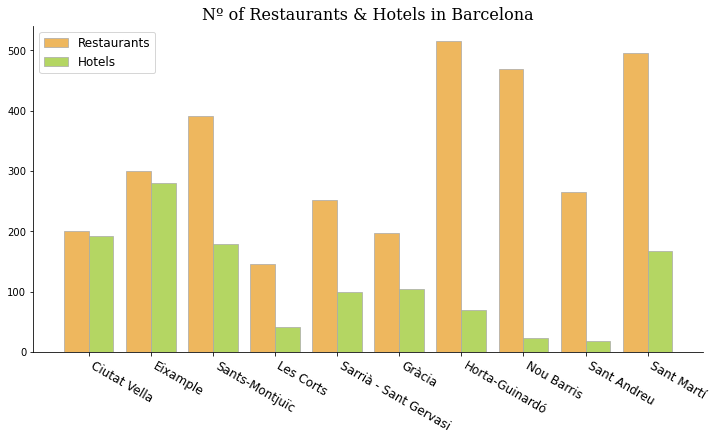

In [32]:
 # Setting the positions and width for the bars
pos = np.arange(len(df_grouped.District_name))
width = 0.4

# Plotting the bars
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(pos - width/2, df_grouped.Restaurants, width, color='#EEB75E',  edgecolor='darkgray', linewidth=0.7)
ax.bar(pos + width/2, df_grouped.Hotels, width, color='#B4D663', edgecolor='darkgray', linewidth=0.7)

# Setting the chart's title
ax.set_title('Nº of Restaurants & Hotels in Barcelona', fontsize=16, fontfamily='serif') # add title to the plot

# Setting the position of the x ticks
ax.set_xticks(pos)
ax.set_xticklabels(df_grouped.District_name,  fontsize=12, rotation=-30, ha="left")
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);


# Adding the legend and showing the plot
plt.legend(['Restaurants','Hotels'], loc='upper left', fontsize=12)
plt.show()

<p> From this plot, we can see that most hotels concentrate in Eixample and Ciutat Vella, which are actually the most touristic parts of the city. In the restaurant category (this category includes any type of food location, from actual restaurants to coffee shops or fast food chains) we can see that, even though the touristic parts of the city do have a considerable amount of restaurants, most of them are actually situated in the last four districts in the plot (Horta-Guinardó, Nou Barris, Sant Andreu, Sant Martí). These districts correspond to the districts with lowest RFD, which probably means that most of these locations are in fact small local bars or coffee shops. </p>

<p> Finally, before clustering, we can plot all this data onto a map to have an idea on what are we trying to group. The number of food locals by neighborhood can be qutie similar, with only low values in the neighborhoods outskirts of the city. Thus, in this case we will plot the number of hotels in the city to check where the touristic center is: </p>

In [47]:
# create map
map_bcn = folium.Map(location=[41.3998976, 2.1587278], tiles='cartodbpositron', zoom_start=13)


# set color scheme for the clusters
colormap = brcm.LinearColormap(colors=['lightgray','#DD619F'], index=[0,df.Hotels.max()],vmin=df.Hotels.min(),vmax=df.Hotels.max())
# add markers to the map
#markers_colors = []
for lat, lon, poi, neigh in zip(df['Latitude'], df['Longitude'], df['Hotels'], df['Neigh_name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color = colormap(poi),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color= colormap(poi),
        fill_opacity=0.7).add_to(map_bcn)
       
map_bcn.add_child(colormap)
map_bcn

<h3> Clustering </h3>

<p> Once we have understood the data we have in hands, we can proceed with the clustering. <br> To do that, we will manipulate the data a bit more. Rather than focus on absolute numbers, it might be more interesting to focus on the ratios. For example, we might consider more important the ratio restaurants/population, since there should be quite a difference between counting 100 restaurants per 1k population than 100k population. We can take the same approach with the number of hotels. By doing that, we will be able to drop the population column of our clustering dataframe for analysis. <br> Finally, we will only have to normalize our data and apply k-means clustering!

In [60]:
df_cluster = df;
df_cluster['Restaurants_ratio'] = 100 * df_cluster.Restaurants / df_cluster.Population;
df_cluster['Hotels_ratio'] = 100 * df_cluster.Hotels / df_cluster.Population;
df_cluster = df_cluster[['RFD','Restaurants_ratio','Hotels_ratio']];
scaler = StandardScaler();
df_cluster = pd.DataFrame(scaler.fit_transform(df_cluster),columns = df_cluster.columns)
df_cluster.head()

,RFD,Restaurants_ratio,Hotels_ratio
0,-0.529779,-0.341951,0.356583
1,0.293019,-0.138446,2.782026
2,-0.331742,-0.115244,3.058551
3,0.135061,-0.228127,1.767288
4,0.302449,-0.290178,0.896225


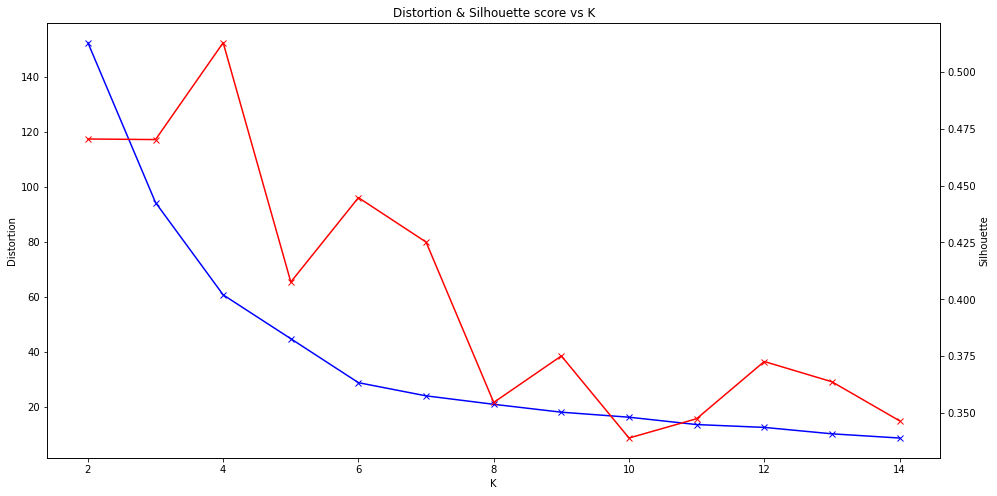

In [74]:
distortions = []
silhouette = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_cluster)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(df_cluster, kmeanModel.labels_, metric='euclidean'))

fig, ax1 = plt.subplots(figsize=(16,8))

ax1.set_xlabel('K')
ax1.set_ylabel('Distortion')
ax1.plot(K, distortions,'bx-')
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Silhouette')  # we already handled the x-label with ax1
ax2.plot(K, silhouette,'rx-')

plt.title('Distortion & Silhouette score vs K')
plt.show()

<p> Using the elbow method and checking the silhouette score, we can determine that the number of optimal clusters is 4. Now we can proceed to join our original dataframe with the assigned cluster and plot it in a map! </p>

In [85]:
kclusters =4;
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster);
# add clustering labels
df_final = df;
df_final.insert(0, 'Cluster Labels', kmeans.labels_)

In [93]:
# create map
map_clusters = folium.Map(location=[41.3998976, 2.1587278], tiles='cartodbpositron', zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [pltcolors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neigh_name'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3> Results and discussion </h3>

<p>From the map above, we can see the distribution of our four clusters in Barcelona, based on the number of hotels, restaurants, population and rent per capita. From here, we can further analyze each of the clusters to determine which are better suited for a gourmet restaurant, and which one for a local coffee shop. </p>

In [122]:
results = [];
result_col = ['Cluster','% Population','RFD','% Restaurants','% Hotels'];
for i in range(kclusters):
    cluster = df_final.loc[df_final['Cluster Labels'] == i, ['District','District_name','Neigh_id','Neigh_name','Population','RFD','Restaurants','Hotels']];
    cluster_pop = 100 * cluster.Population.sum()/df_final.Population.sum();
    cluster_rfd = sum(cluster.RFD * cluster.Population)/cluster.Population.sum()
    cluster_rest = 100 * cluster.Restaurants.sum()/df_final.Restaurants.sum();
    cluster_hotel = 100 * cluster.Hotels.sum()/df_final.Hotels.sum();
    results.append([i,cluster_pop,cluster_rfd,cluster_rest,cluster_hotel])
    
df_results = pd.DataFrame(results, columns=result_col);
df_results.round(2)

,Cluster,% Population,RFD,% Restaurants,% Hotels
0,0,8.45,102.92,12.31,26.87
1,1,75.30,83.46,70.90,54.25
2,2,0.11,58.55,2.88,0.26
3,3,16.14,175.58,13.91,18.62


<p> The above dataframe includes a summary of the data in each of the clusters. From here, and with help of the cluster map, we can easily describe each of them: </p> <br>
<li><b>Cluster 0:</b>Not much population and slightly above average RFD. For the small population it has, there are quite a lot of restaurants and hotels. In the map is represented by the color red and it is mostly situated in the coast and center of Barcelona, most of the touristic places. This is a <b> Touristic cluster </b>. </li>
<li><b>Cluster 1:</b>It includes most of the population in Barcelona (purple in the map), with most of its restaurants and hotels, even though the percentage of hotels lags behind compared to the percentage of population it represesents (75% population vs 54% of the hotels). Adding to that, the RFD  is 83.46 (below average), which implies that most of these neighborhoods are working class. This would be our <b>Average cluster</b>.</li>
<li><b>Cluster 2:</b>Only two neighborhoods are represented in this cluster, which has way below average RFD and represent a small percentage of the population. This is our <b>Underdevelop cluster</b>.</li>
<li><b>Cluster 3:</b>It represents 16% of the population and has a higher percentage of hotels than restaurants. The RFD is way above the average (175) which implies these are quite affluent neighbourhoods. In fact, we can see in the map that most of them are situated in the upper part of the city, which corresponds to the richer part. This would be our <b>Affluent cluster</b>.</li>

<p>From here on, we should decide where to open our coffee shop and where the gourmet restaurant should be. </p>
<li><b>Local coffee shop</b>:Should be situated in the <b>Average Cluster (1)</b>, purple in the map. It has the highest amount of population to serve and highest percentage of restaurants. The rent per capita indicates that it is working class, which would also be suitable for this kind of local.</li>
<li><b>Gourmet restaurant</b>: Should be situated either in <b>Touristic cluster (0) or Affluent cluster (3)</b>, depending on which kind of clientele it caters. If the touristic cluster is chosen, it should not be an extremely exclusive restaurant, serving typical spanish food, which would benefit from the higher number of hotels in the zone. If the affluent cluster is chosen, I think you could go all-in in the exclusiveness of the local.</li>